In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import time
# imports

In [95]:
# dataset class for loading images and labels
class ISICDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Create a mapping of class names to integers
        label_columns = self.annotations.columns[1:]  # All columns except the first one
        self.class_name_to_idx = {class_name: idx for idx, class_name in enumerate(label_columns)}

        # Convert one-hot encoded class names to single integer labels
        self.annotations['label'] = self.annotations.iloc[:, 1:].idxmax(axis=1).map(self.class_name_to_idx)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        filename = self.annotations.iloc[idx, 0] + ".jpg"
        img_name = os.path.join(self.root_dir, filename)

        image = Image.open(img_name).convert("RGB")
        label = int(self.annotations.iloc[idx, -1])

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_class_mapping(self):
        return self.class_name_to_idx

In [3]:
# preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Define paths and CSV files
train_csv = r"C:\Users\emman\Documents\AI_assignment\Training\ISIC2018_Task3_Training_GroundTruth\ISIC2018_Task3_Training_GroundTruth\ISIC2018_Task3_Training_GroundTruth.csv"
train_dir = r"C:\Users\emman\Documents\AI_assignment\Training\ISIC2018_Task3_Training_Input\ISIC2018_Task3_Training_Input"


val_csv = r"C:\Users\emman\Documents\AI_assignment\Validation\ISIC2018_Task3_Validation_GroundTruth\ISIC2018_Task3_Validation_GroundTruth\ISIC2018_Task3_Validation_GroundTruth.csv"
val_dir = r"C:\Users\emman\Documents\AI_assignment\Validation\ISIC2018_Task3_Validation_Input\ISIC2018_Task3_Validation_Input"

test_csv = r"C:\Users\emman\Documents\AI_assignment\Test\ISIC2018_Task3_Test_GroundTruth\ISIC2018_Task3_Test_GroundTruth\ISIC2018_Task3_Test_GroundTruth.csv"
test_dir = r"C:\Users\emman\Documents\AI_assignment\Test\ISIC2018_Task3_Test_Input\ISIC2018_Task3_Test_Input"


In [5]:
# Load datasets with debugging
train_dataset = ISICDataset(csv_file=train_csv, root_dir=train_dir, transform=transform)
val_dataset = ISICDataset(csv_file=val_csv, root_dir=val_dir, transform=transform)
test_dataset = ISICDataset(csv_file=test_csv, root_dir=test_dir, transform=transform)

In [96]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Model Training Pipeline

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [99]:
# Load a pre-trained ResNet18 model and modify the final layer
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 7) 

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [100]:
# Loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [101]:
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [11]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_running_loss = 0.0
        
        corrects = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                corrects += torch.sum(preds == labels)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_accuracy = corrects.double() / len(val_loader.dataset)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

Epoch 1/10, Loss: 0.2913, Val Loss: 0.2230, Val Acc: 0.8964
Epoch 2/10, Loss: 0.2615, Val Loss: 0.2111, Val Acc: 0.8964
Epoch 3/10, Loss: 0.2502, Val Loss: 0.1743, Val Acc: 0.9223
Epoch 4/10, Loss: 0.2511, Val Loss: 0.2082, Val Acc: 0.9378
Epoch 5/10, Loss: 0.2455, Val Loss: 0.6561, Val Acc: 0.6373
Epoch 6/10, Loss: 0.2373, Val Loss: 0.2015, Val Acc: 0.9067
Epoch 7/10, Loss: 0.2368, Val Loss: 0.1914, Val Acc: 0.9067
Epoch 8/10, Loss: 0.2242, Val Loss: 0.2015, Val Acc: 0.9016
Epoch 9/10, Loss: 0.2426, Val Loss: 0.2034, Val Acc: 0.9016
Epoch 10/10, Loss: 0.2264, Val Loss: 0.2001, Val Acc: 0.9016


In [83]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# imports for eval

In [103]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
val_loss, val_acc, val_labels, val_preds, val_probs = evaluate_model(model, dataloaders['val'], criterion, device)
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Test Dataset Class (using updated ISICDataset class)
test_dataset = ISICDataset(csv_file=test_csv, root_dir=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class mapping to verify
class_mapping = test_dataset.get_class_mapping()
print("Class Mapping:", class_mapping)

Class Mapping: {'MEL': 0, 'NV': 1, 'BCC': 2, 'AKIEC': 3, 'BKL': 4, 'DF': 5, 'VASC': 6}


Classification Report:
              precision    recall  f1-score   support

         MEL       0.00      0.00      0.00       171
          NV       0.68      0.10      0.18       909
         BCC       0.00      0.00      0.00        93
       AKIEC       0.05      0.70      0.10        43
         BKL       0.15      0.18      0.16       217
          DF       0.00      0.00      0.00        44
        VASC       0.04      0.54      0.07        35

    accuracy                           0.12      1512
   macro avg       0.13      0.22      0.07      1512
weighted avg       0.43      0.12      0.14      1512



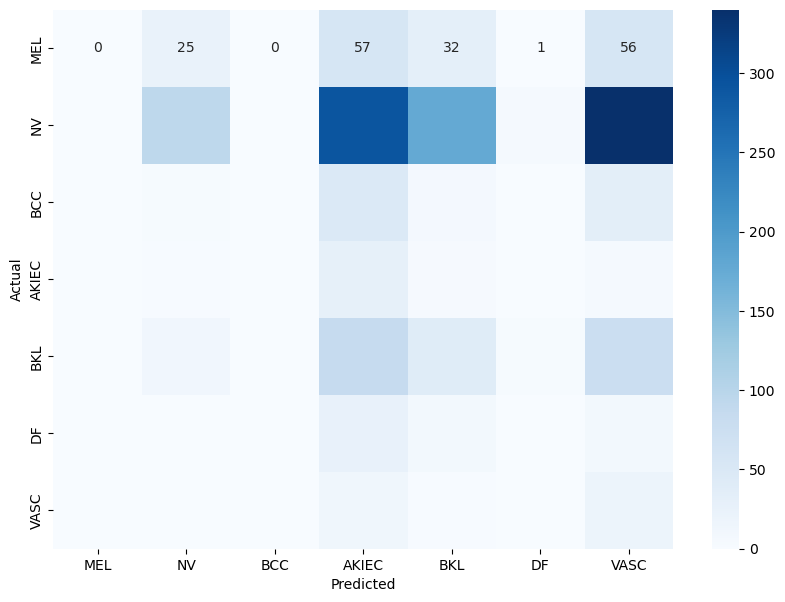

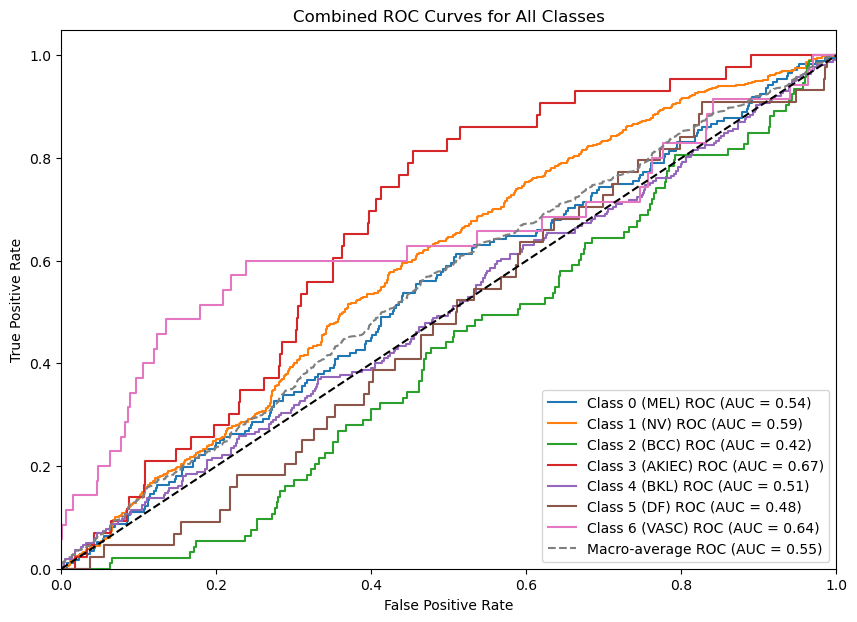

In [106]:
# Evaluation function with ROC curve and Confusion Matrix
def evaluate_and_plot_combined_roc(model, data_loader, class_mapping):
    num_classes = len(class_mapping)
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)  # Ensure images are on GPU
            labels = labels.to(device)  # Ensure labels are on GPU
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_probs.extend(probs.cpu().numpy())  # Move back to CPU for evaluation
            all_preds.extend(preds.cpu().numpy())  # Move back to CPU for evaluation
            all_labels.extend(labels.cpu().numpy())  # Move back to CPU for evaluation

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=list(class_mapping.keys()), zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(class_mapping.keys()), yticklabels=list(class_mapping.keys()))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Convert lists to NumPy arrays
    all_probs = np.array(all_probs)
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate ROC curves for each class
    for i in range(num_classes):
        if np.sum(all_labels_bin[:, i]) == 0:
            print(f"Warning: No positive samples for class {i}")
            continue

        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes) if i in fpr]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        if i in fpr:
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves on the same graph
    plt.figure(figsize=(10, 7))
    for i in range(num_classes):
        if i in roc_auc:
            plt.plot(fpr[i], tpr[i], label=f'Class {i} ({list(class_mapping.keys())[i]}) ROC (AUC = {roc_auc[i]:.2f})')

    # Plot the macro-average ROC curve
    plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})', linestyle='--')

    # Add plot details
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Combined ROC Curves for All Classes')
    plt.legend(loc='lower right')
    plt.show()

evaluate_and_plot_combined_roc(model, test_loader, class_mapping)